In [1]:
import pygsti
from scipy.linalg import expm
import numpy as np
from pygsti.tools import unitary_to_superop
from pygsti.modelpacks import smq1Q_XYZI
from matplotlib import pyplot as plt
from pygsti.circuits import Circuit
from quapack.pyRPE import RobustPhaseEstimation
from quapack.pyRPE.quantum import Q as _rpeQ
from tqdm import tqdm
from importlib import reload

In [2]:
def dampled_exponential(n, freq, phi, decay):
    return np.exp(-n*(decay+1j*freq)) * np.exp(1j*phi)

def make_cos_prob(depth, phase, decay, spam_depol):
    return (1 + np.exp(-(spam_depol + depth*decay)) * np.cos(depth*phase))/2

def make_sin_prob(depth, phase, decay, spam_depol):
    return (1 + np.exp(-(spam_depol + depth*decay)) * np.sin(depth*phase))/2

def make_cos_deriv(depth, phase, decay, spam_depol):
    return -depth*np.exp(-(spam_depol + depth*decay)) * np.sin(depth*phase)/2

def make_sin_deriv(depth, phase, decay, spam_depol):
    return depth*np.exp(-(spam_depol + depth*decay)) * np.cos(depth*phase)/2

def sample_data(n_samples, depths, phase, decay, spam_depol):
    cos_samples = []
    sin_samples = []
    for depth in depths:
        cos_samples.append(np.random.binomial(n_samples, make_cos_prob(depth, phase, decay, spam_depol)))
        sin_samples.append(np.random.binomial(n_samples, make_sin_prob(depth, phase, decay, spam_depol)))
    return np.array(cos_samples), np.array(sin_samples)

def format_complex_signal(cos_samples, sin_samples, num_shots_per_circuit):
    return (1-2*(cos_samples/num_shots_per_circuit)) + 1j*(1-2*(sin_samples/num_shots_per_circuit))

In [3]:
n_samples = 1000
phase = 0.1
decay = 0.0
spam_depol = 0
depths = [2**i for i in range(10)]

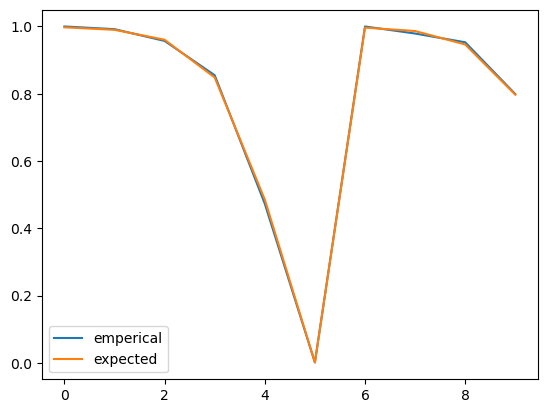

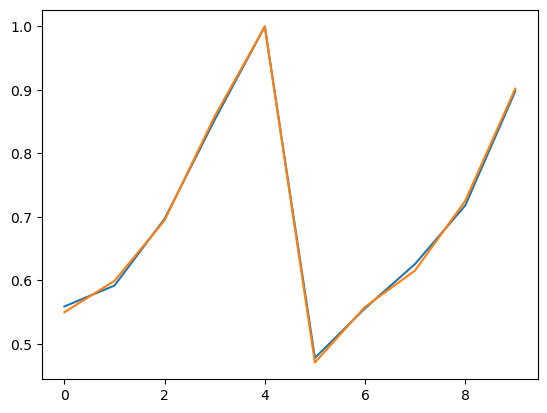

In [4]:

cos_samples, sin_samples = sample_data(n_samples, depths, phase, decay, spam_depol)
plt.plot(cos_samples/n_samples, label='emperical')
plt.plot([make_cos_prob(d, phase, decay, spam_depol) for d in depths], label='expected')
plt.legend()
plt.show()
plt.figure()
plt.plot(sin_samples/n_samples, label='emperical')
plt.plot([make_sin_prob(d, phase, decay, spam_depol) for d in depths], label='expected')

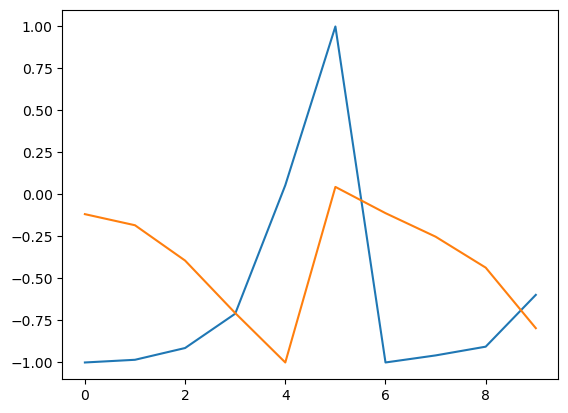

In [5]:
signal = format_complex_signal(cos_samples, sin_samples, n_samples)
plt.figure()
plt.plot(np.real(signal), label='real')
plt.plot(np.imag(signal), label='imag')

In [6]:
def make_vandermont_vector(omega, depths, decay=0.0):
    return np.array([np.exp(-decay*d-1j*omega*d) for d in depths])

In [7]:
def make_correlation_matrix(signal):
    return np.outer(signal, np.conj(signal))/len(signal)

In [8]:
def make_noise_subspace_matrix(signal):
    cmat = make_correlation_matrix(signal)
    evals, evecs = np.linalg.eig(cmat)
    # the noise subspace is the eigenvectors corresponding to all but the largest eigenvalue
    # remove the largest eigenvalue -- they are not sorted
    eval_norms = np.abs(evals)
    max_idx = np.argmax(eval_norms)
    # remove the max index
    evals = np.delete(evals, max_idx)
    evecs = np.delete(evecs, max_idx, axis=1)
    return evecs

In [9]:
def music_norm(signal, omega, depths, decay=0.0):
    noise_subspace = make_noise_subspace_matrix(signal)
    vandermonde = make_vandermont_vector(omega, depths, decay)
    return 1/sum([np.abs(np.dot(vandermonde.T, noise_subspace[:, i]))**2 for i in range(noise_subspace.shape[1])])

In [10]:
def make_rpe_estimate(cos_shots, sin_shots, n_samples, depths):
    experiment = _rpeQ()
    for idx, d in enumerate(depths):
        experiment.process_cos(d, (int(cos_shots[idx]), int(n_samples-cos_shots[idx])))
        experiment.process_sin(d, (int(sin_shots[idx]), int(n_samples-sin_shots[idx])))
    analysis = RobustPhaseEstimation(experiment)
    last_good_generation = analysis.check_unif_local(historical=True)
    estimates = analysis.angle_estimates
    return estimates, last_good_generation


In [11]:
n_samples = 1000
phase = np.pi/2+0.4
decay = 0.1
spam_depol = 0
depths = [2**i for i in range(10)]
cos_samples, sin_samples = sample_data(n_samples, depths, phase, decay, spam_depol)
signal = format_complex_signal(cos_samples, sin_samples, n_samples)

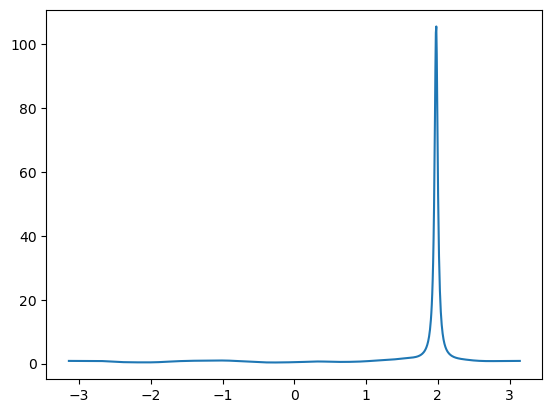

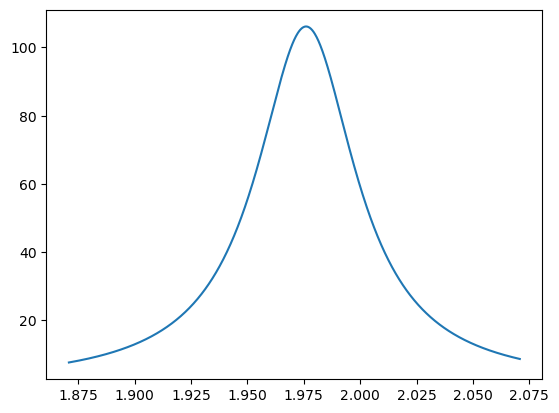

In [12]:
decay_estimate = decay
omegas = np.linspace(-np.pi, np.pi, 1000)
music_norms = [music_norm(signal, omega, depths, decay=decay_estimate) for omega in omegas]
plt.figure()
plt.plot(omegas, music_norms)
# also plot the norm zoomed in 
plt.figure()
omegas_refined = np.linspace(phase-0.1, phase+0.1, 1000)
music_norms_refined = [music_norm(signal, omega, depths, decay=decay_estimate) for omega in omegas_refined]
plt.plot(omegas_refined, music_norms_refined)


In [13]:
# now we can use the music norm to estimate the phase
# we will use the phase that maximizes the music norm
rough_estimate = omegas[np.argmax(music_norms)]
height_of_rough_estimate = np.max(music_norms)
print("Rough estimate error", np.abs(rough_estimate - phase))

Rough estimate error 0.007243492132010143


In [14]:
from scipy.signal import find_peaks
refined_omegas = np.linspace(rough_estimate-0.01, rough_estimate+0.01, 1000)
music_norms_refined = [music_norm(signal, omega, depths, decay=decay_estimate) for omega in refined_omegas]
peaks, _ = find_peaks(music_norms_refined, height=height_of_rough_estimate/2)
peak_omega = refined_omegas[peaks[0]]
print("Peak fitted error", np.abs(peak_omega - phase))

Peak fitted error 0.0052114600999781935


In [15]:
# use an optimizer to find the phase
from scipy.optimize import minimize
res = minimize(lambda x: -music_norm(signal, x, depths, decay=decay_estimate), phase)
optimized_esitmate = res.x
print("Optimized estimate error", np.abs(optimized_esitmate - phase))

Optimized estimate error [0.00520187]


In [16]:
rpe_estimates, last_good_generation = make_rpe_estimate(cos_samples, sin_samples, n_samples, depths)
print("rpe estimate error", np.abs(rpe_estimates[last_good_generation]-phase))
print("last good generation", last_good_generation)

rpe estimate error 0.013620527359575751
last good generation 7


In [17]:
rpe_estimates

array([1.95257605, 1.97552058, 1.97584002, 1.97427111, 1.97328303,
       1.96126705, 1.97688143, 1.98441685, 1.97347037, 1.97576725])

In [18]:
phase

1.9707963267948965

In [19]:
def bootstrap_comparison(num_bootstraps, num_samples, depths, phase, decay, spam_depol):
    errors = []
    for _ in tqdm(range(num_bootstraps)):
        cos_samples, sin_samples = sample_data(num_samples, depths, phase, decay, spam_depol)
        signal = format_complex_signal(cos_samples, sin_samples, num_samples)
        rpe_estimates, last_good_generation = make_rpe_estimate(cos_samples, sin_samples, num_samples, depths)
        rpe_error = np.abs(rpe_estimates[last_good_generation]-phase)
        omegas = np.linspace(-np.pi, np.pi, 1000)
        music_norms = [music_norm(signal, omega, depths) for omega in omegas]
        rough_estimate = omegas[np.argmax(music_norms)]
        height_of_rough_estimate = np.max(music_norms)
        refined_omegas = np.linspace(rough_estimate-0.01, rough_estimate+0.01, 1000)
        music_norms_refined = [music_norm(signal, omega, depths, decay=decay) for omega in refined_omegas]
        peaks, _ = find_peaks(music_norms_refined, height=height_of_rough_estimate/2)
        peak_omega = refined_omegas[peaks[0]]
        optimized_estimate = minimize(lambda x: -music_norm(signal, x, depths), phase).x[0]
        error_dict_at_boot = {
            'rpe': rpe_error,
            'peak': np.abs(peak_omega - phase),
            'optimized': np.abs(optimized_estimate - phase)
        }
        errors.append(error_dict_at_boot)
    return errors

In [20]:
n_samples = 100
num_bootstraps = 100
phase = np.pi/2+0.2
decay = 0.001
spam_depol = 0.001
depths = [2**i for i in range(10)]
errors = bootstrap_comparison(num_bootstraps, n_samples, depths, phase, decay, spam_depol)

100%|██████████| 100/100 [00:29<00:00,  3.41it/s]


In [21]:
average_errors = {key: np.mean([error[key] for error in errors]) for key in errors[0].keys()}
print(average_errors)

{'rpe': 0.00024680523344275726, 'peak': 0.0003233233233233235, 'optimized': 0.00032546040716725734}


In [22]:
def calc_fisher_information(depths, num_shots_per_circuit, phase, decay, spam_depol):
    p_cos = [make_cos_prob(d, phase, decay, spam_depol) for d in depths]
    p_sin = [make_sin_prob(d, phase, decay, spam_depol) for d in depths]
    fisher_information = 0
    for cos_prob, sin_prob, d in zip(p_cos, p_sin, depths):
        fisher_information += num_shots_per_circuit*(make_cos_deriv(d, phase, decay, spam_depol)**2/(cos_prob*(1-cos_prob)) + make_sin_deriv(d, phase, decay, spam_depol)**2/(sin_prob*(1-sin_prob)))
    return fisher_information

def make_cr_bound(depths, num_shots_per_circuit, phase, decay, spam_depol):
    fisher_information = calc_fisher_information(depths, num_shots_per_circuit, phase, decay, spam_depol)
    return 1/np.sqrt(fisher_information)

In [23]:
make_cr_bound(depths, n_samples, phase, decay, spam_depol)

0.00023554305344676953

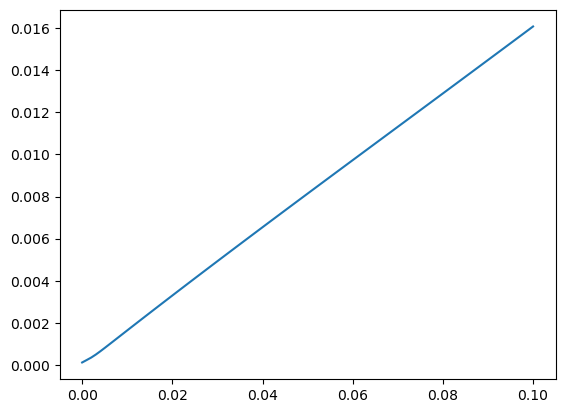

In [24]:
# plot cr bound as a function of the decay
decays = np.linspace(0, 0.1, 100)
cr_bounds = [make_cr_bound(depths, n_samples, phase, decay, spam_depol) for decay in decays]
plt.figure()
plt.plot(decays, cr_bounds)

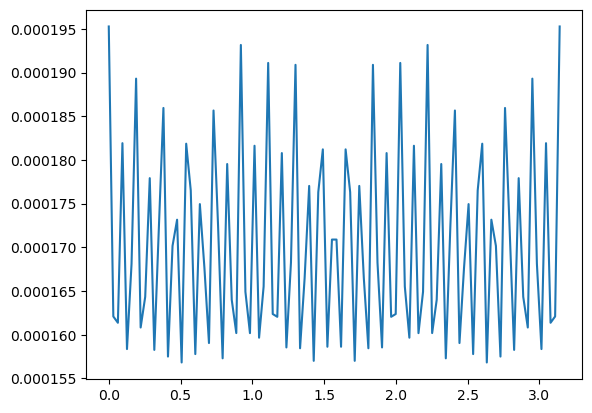

In [25]:
# plot cr bounds a a function of the phase
phases = np.linspace(0, np.pi, 100)
decay = 0.0001
spam_depol = 0.1
cr_bounds = [make_cr_bound(depths, n_samples, phase, decay, spam_depol) for phase in phases]
plt.figure()
plt.plot(phases, cr_bounds)

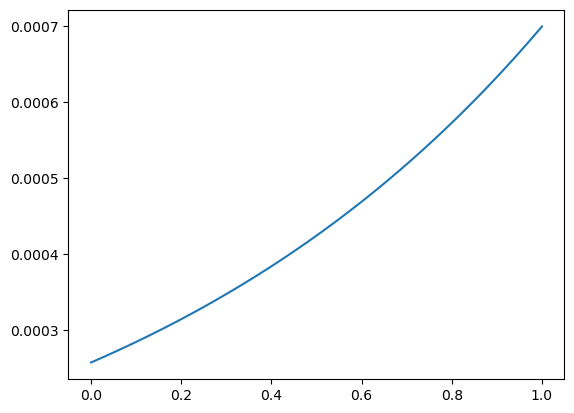

In [26]:
# plot cr bounds as a function of the number spam depolarizing
spam_depol = np.linspace(0, 1, 100)
decay = 0.001
phase = np.pi/2
plt.figure()
cr_bounds = [make_cr_bound(depths, n_samples, phase, decay, spam_depol) for spam_depol in spam_depol]
plt.plot(spam_depol, cr_bounds)